In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from unidecode import unidecode
import seaborn as sns
import warnings
from matplotlib.font_manager import FontProperties


%matplotlib notebook
warnings.filterwarnings('ignore')

## Getting a List of All Right Backs

In [2]:
df = pd.read_table('RB.txt', skiprows = 0, header = None)
df = df.fillna(axis = 'index', method = 'ffill')
df = df.drop_duplicates(subset = 0, keep = 'last')

In [3]:
chng = {
    0 : 'Player',
    1:'Country',
    5:'Age',
    7:'Club'
}

cols = list(chng.values())

In [4]:
df = df.rename(axis = 'columns', mapper = chng)[cols]
df.to_csv('RB2019.csv')

In [5]:
#If you want more, start from the next page of 
# https://www.fifaindex.com/players/8/?position=3&order=desc
# and paste it into RB.txt

## Getting and Cleaning the Statistics

In [6]:
stats = pd.read_csv('RBStats2019.csv')
stats = stats.set_index('Player Name')

In [7]:
fdf = df.join(stats, on = 'Player')

Need to Convert the foreign characters to english

In [8]:
names = df['Player'].values

#Decoding and concerting to plain text, and having dictionaries to convert between
plydict = {i: unidecode(i) for i in names}
realdict = {unidecode(i): i for i in names}
df['Player'] = list(plydict.values())

Mapping Single Named Players with Two Names

In [9]:
#All the Players who are there in the stats dataset but NOT in Right Back Dataset
missing = fdf['Team'].isna()

#All the players in the stats dataset
substr_list = stats.index.values.astype('str')

#All Player in RB dataset
names = list(plydict.values())

In [10]:
conv = {}

#For all players in the stats dataset
for i in substr_list:
    
    #Get Last Name
    s = i.split()[-1]
    
    #For all player in the RB Dataset
    for x in names:
        
        if x == s:
            conv[x] = i

In [11]:
df['Player'] = df['Player'].replace(conv)
fdf = df.join(stats, on = 'Player')

Getting Players with data only

In [12]:
missing = fdf['Team'].isna()
fdf = fdf[~missing]

Combining league and UCL data

In [13]:
fdf.columns

Index(['Player', 'Country', 'Age', 'Club', 'Team', 'League', 'POS', 'GP',
       'MIN', 'Y', 'YR', 'R', 'A', 'SA', 'CR', 'ACR', 'CC', 'FS', 'P', 'AP',
       'ACRO', 'BCC', 'DR', 'APW', 'TBOX', 'ECL'],
      dtype='object')

In [14]:
cols = [
    'Player', 'Country', 'Age', 'Club','MIN',
    
    #Attacking Stats
    'A',
    #'SA',
    'ACR',
    'FS',
    'CR',
    'AP',
    'ACRO',
    'CC',
    'P',
    #'BCC',
    'DR',
    #'APW',
    'TBOX'
]


adf = fdf.groupby(cols[:4])[cols[4:]].sum()

#Greater than 900 Minutes
logic = adf['MIN'] > 900
adf = adf[logic]


#Crossing %
acc_crosses = adf['ACR'] + adf['ACRO']
crosses = adf['CR']
adf['CRrat'] = (acc_crosses/crosses) * acc_crosses
cols = cols + ['CRrat']

#Passing %
adf['P%'] = (adf['P']/adf['AP']) * 100
cols = cols + ['P%']


original_df = adf.copy()

rm =['CR', 'ACR', 'ACRO', 'AP', 'P']
for i in rm:
    cols.remove(i)


adf = adf.reset_index()
adf = adf[cols]

In [15]:
cols[6:-1]

['FS', 'CC', 'DR', 'TBOX', 'CRrat']

In [16]:
adf.columns

Index(['Player', 'Country', 'Age', 'Club', 'MIN', 'A', 'FS', 'CC', 'DR',
       'TBOX', 'CRrat', 'P%'],
      dtype='object')

In [17]:
adf.sort_values(by = 'P%', ascending=False).head()

,Player,Country,Age,Club,MIN,A,FS,CC,DR,TBOX,CRrat,P%
91,Nico Elvedi,Switzerland,22.0,M'gladbach,2625.0,1.0,14.0,3.0,9.0,21.0,0.000000,92.698259
115,Thilo Kehrer,Germany,22.0,Paris,2292.0,2.0,20.0,7.0,8.0,28.0,1.333333,92.518703
99,Rafinha,Brazil,33.0,FC Bayern,1568.0,2.0,19.0,11.0,10.0,17.0,8.909091,91.628615
6,Alvaro Odriozola,Spain,23.0,Real Madrid,1406.0,2.0,21.0,21.0,9.0,55.0,9.657143,91.460055
90,Nelson Semedo,Portugal,25.0,FC Barcelona,2151.0,0.0,36.0,8.0,30.0,54.0,0.166667,91.130186


## Interpreting the Data

In [49]:
reqs = [
    'Player',
    'Club',
    'Country',
    'MIN',
    'Age'
]

def per90(df1 ,df2, x):
    for i in x:
        df1[i + '90'] = df2[i]/df2['MIN'] * 90
        
    return df1

def sum_vals(d):
    n = len(sts90)
    sm = 0
    for i in range(n):
        wt = d[i]/mxs[i]
        sm = sm + wt * d[i]
    return sm

def sum_wts(d):
    n = len(sts90)
    sm = 0
    for i in range(n):
        wt = d[i]/mxs[i]
        sm = sm + wt
    return sm



df = adf[reqs]
sts = cols[6: -1]
sts90 = [i + '90' for i in sts]

#Convert to per 90 stats
df = per90(df, adf, sts)

mxs = [df[i].max() for i in sts90]

#Get Sum of Values, and Sum of their weights
df['SumVal'] = df[sts90].apply(sum_vals, axis = 1)
df['SumWt'] = df[sts90].apply(sum_wts, axis = 1)


In [50]:
#Include only players who have played certion number of minutes

logic = (df['MIN'] > 900) & (df['Age'] < 29.0)
xdf = df[logic]

In [51]:
xdf = xdf.sort_values(by = 'SumVal', ascending=False)
xdf.head()

,Player,Club,Country,MIN,Age,FS90,CC90,DR90,TBOX90,CRrat90,SumVal,SumWt
130,Youcef Atal,OGC Nice,Algeria,2171.0,22.0,2.404422,0.912022,3.979733,3.938277,0.213792,10.105677,3.233009
6,Alvaro Odriozola,Real Madrid,Spain,1406.0,23.0,1.344239,1.344239,0.576102,3.520626,0.618167,4.724676,2.298110
58,Joao Cancelo,Juventus,Portugal,2446.0,24.0,1.214227,1.545380,2.612428,2.097302,0.912566,4.664008,2.622088
65,Joshua Kimmich,FC Bayern,Germany,3690.0,24.0,1.609756,2.390244,0.975610,1.634146,1.023248,4.587037,2.620190
71,Kieran Trippier,Spurs,England,2814.0,28.0,0.895522,2.302772,0.287846,1.119403,1.626065,3.981728,2.322464


In [52]:
#Dropping Certain Players

xdf = xdf.drop(130, axis = 'index')
xdf = xdf.drop(64, axis = 'index')
xdf = xdf.drop(96, axis = 'index')

In [53]:
for i in sts90:
    print(i, len(xdf[xdf[i] == 0]))

FS90 0
CC90 0
DR90 0
TBOX90 0
CRrat90 2


## Visalizing Data

In [54]:
#How many players you want
vdf = xdf.iloc[:30]
vdf.head()

ixs = vdf.index

In [55]:
vdf.columns

Index(['Player', 'Club', 'Country', 'MIN', 'Age', 'FS90', 'CC90', 'DR90',
       'TBOX90', 'CRrat90', 'SumVal', 'SumWt'],
      dtype='object')

<IPython.core.display.Javascript object>


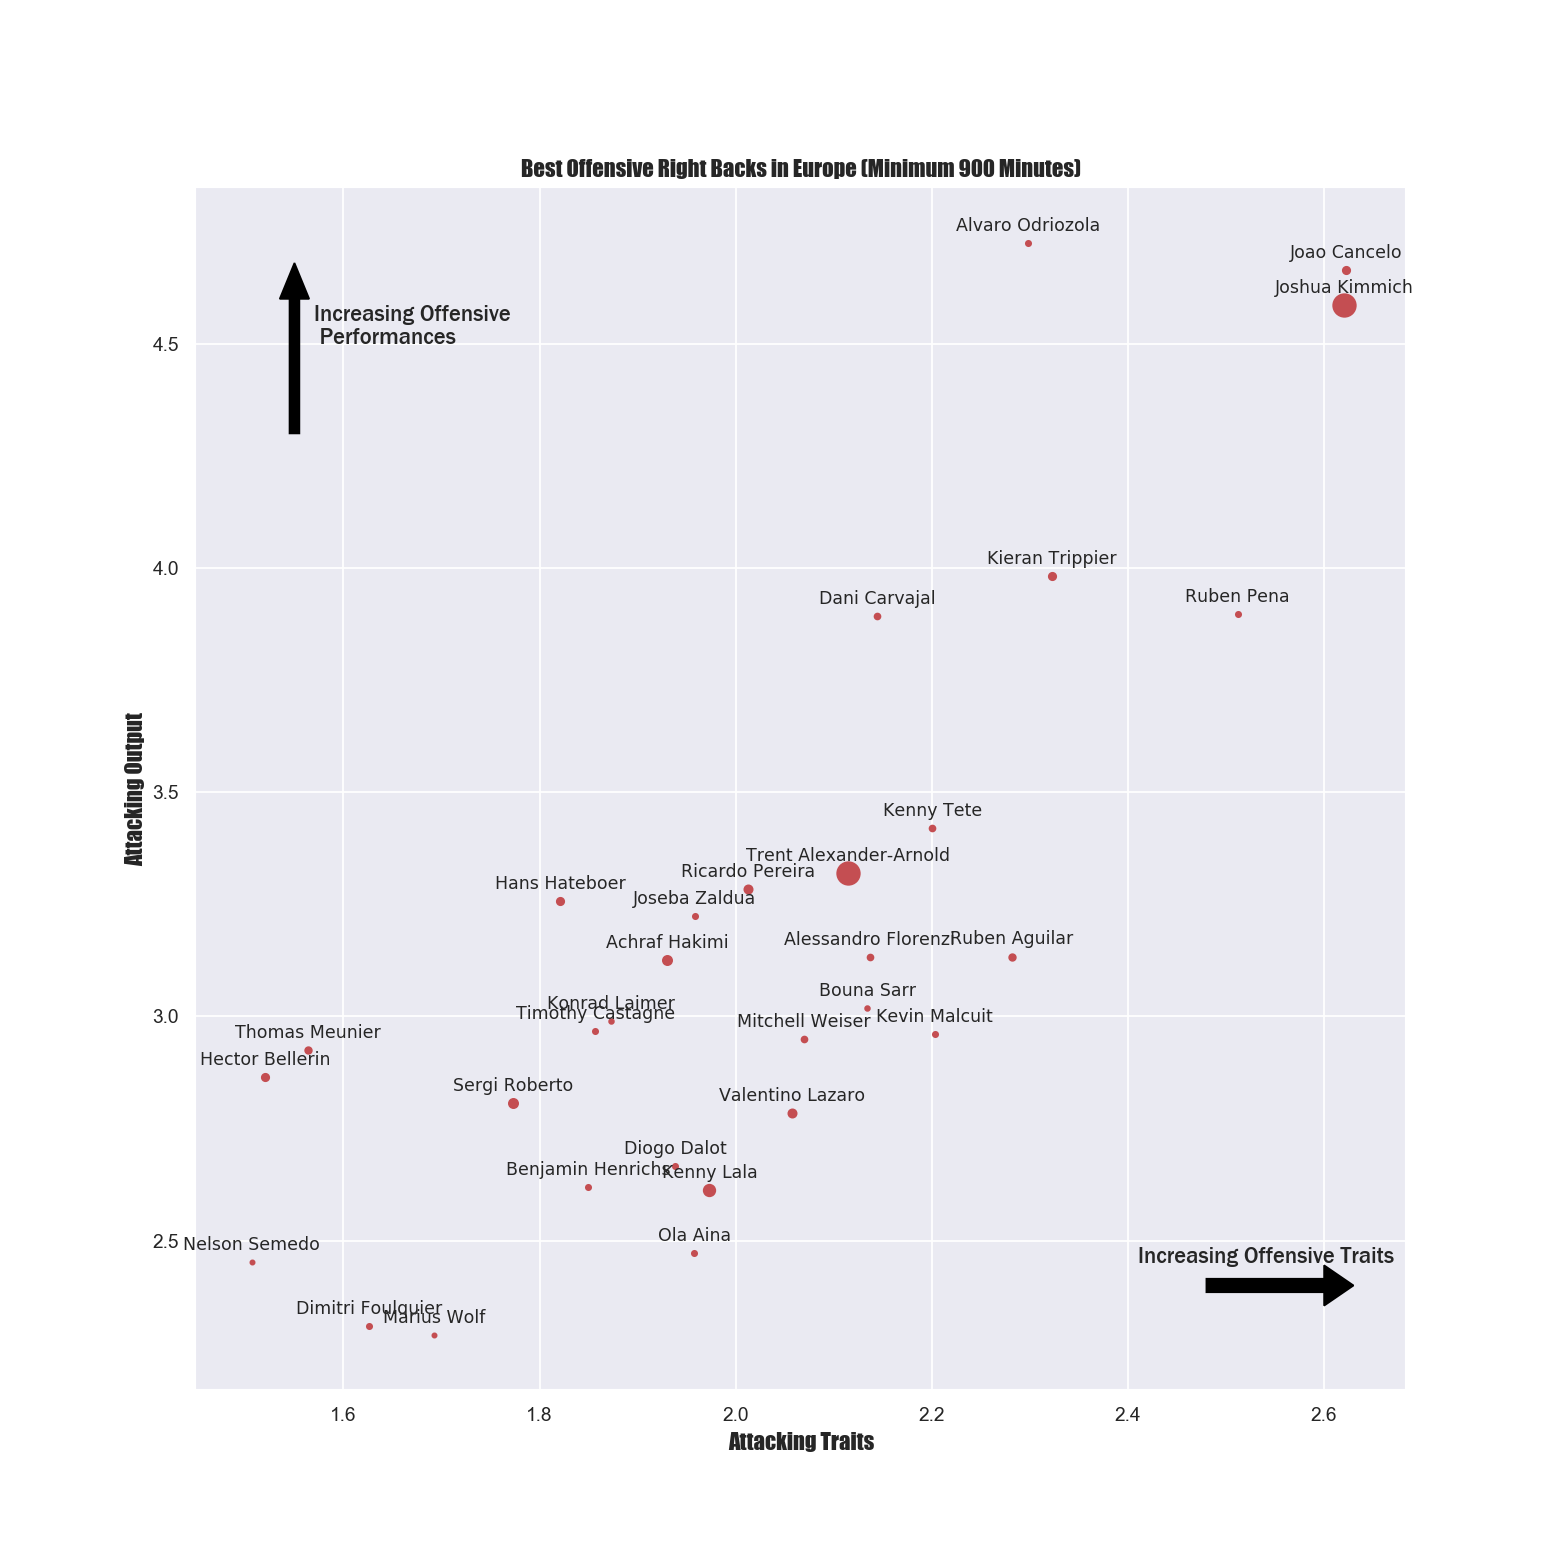

In [56]:
sns.set()

#ax = vdf.plot.scatter('SumWt', 'SumVal', figsize = (10, 10))

fig = plt.figure(figsize = (12.5, 12.5))

vdf = vdf.sort_values(by = 'SumWt', ascending=True)
n = vdf['Player'].values

ixs = vdf.index
x = vdf['SumWt'].values
y = vdf['SumVal'].values

#sz = vdf['P%'].values
sz = adf.iloc[ixs]['A'].values + 8

hfont = {'fontname':'Helvetica'}
config = {
    'ha': 'center', 
    'va': 'center'
}

for i, txt in enumerate(n):
    if i != 0:
        disx = x[i] - x[i-1]
        if disx > 0.0001:
            plt.scatter(x[i], y[i], c = 'r', s= (1.25)**sz[i])
            plt.text(x[i], y[i]+ 0.038, txt,config,  fontsize = 10, rotation = 0, family = 'MS Gothic')
    else:
        plt.scatter(x[i], y[i], c = 'r', s= (1.25)**sz[i])
        plt.text(x[i], y[i]+ 0.038, txt, config,  fontsize = 10, rotation = 0, family = 'MS Gothic')

plt.arrow(2.48, 2.4, 0.12, 0, width = 0.03, head_length = 0.03, color = 'black')
plt.text(2.41, 2.45, "Increasing Offensive Traits", fontsize = 13, family = "Franklin Gothic Medium")

plt.arrow(1.55, 4.3, 0, 0.3, width = 0.01, head_length = 0.08, color = 'black' )
plt.text(1.57, 4.5, "Increasing Offensive\n Performances", fontsize = 13, family = "Franklin Gothic Medium")

plt.gcf().text(0.5, 2, "Yo", fontsize=14, transform=plt.gcf().transFigure)


fig = plt.gcf()
ax = plt.gca()
ax.set_xlabel('Attacking Traits', family = "Impact", fontsize = 13)
ax.set_ylabel('Attacking Output', family = "Impact", fontsize = 13)
ax.set_title('Best Offensive Right Backs in Europe (Minimum 900 Minutes)', family = 'Impact', fontsize = 13)
fig.savefig('rb.jpg', dpi = 300, facecolor = 'white')

## Provide Ranking System

In [167]:
xdf.set_index('Player').loc['Thomas Meunier']

Club          Paris
Country     Belgium
MIN            1888
Age              27
FS90       0.238347
CC90        1.00106
DR90       0.429025
TBOX90      3.05085
CRrat90    0.422425
SumVal      2.92585
SumWt       1.56351
Name: Thomas Meunier, dtype: object

In [168]:
def get_ranks(df, sts90):
    for i in sts90:
        df[i + ' Rank'] = df[i].rank(ascending = False)
        
    return df
t = get_ranks(xdf, sts90)

In [166]:
sts90

['FS90', 'CC90', 'DR90', 'TBOX90', 'CRrat90']

In [170]:
t.set_index('Player').loc['Diogo Dalot']

Club            Manchester Utd
Country               Portugal
MIN                       1257
Age                         20
FS90                  0.143198
CC90                   1.28878
DR90                   1.14558
TBOX90                 1.64678
CRrat90                1.46181
SumVal                 2.66677
SumWt                  1.93812
FS90 Rank                   84
CC90 Rank                   16
DR90 Rank                   21
TBOX90 Rank                 25
CRrat90 Rank                 5
Name: Diogo Dalot, dtype: object

### Best U23 Prospects

In [42]:
logic = (df['MIN'] > 900) & (df['Age'] < 24.0)
xdf = df[logic].sort_values(by = 'SumVal', ascending = False)


pdf = xdf.iloc[:20]